# Traffic Light Controller for a Single 4-Way Road Intersection using Double Deep Q-Network

## Installations

We use SUMO (Simulation of Urban MObility) for simulating the traffic environment

In [1]:
!sudo apt-get install -y sumo sumo-tools sumo-doc
!pip install sumolib traci
!pip install torchviz
!pip install stable-baselines3 gym




The following additional packages will be installed:
  binfmt-support fastjar fonts-roboto-unhinted gdal-data jarwrapper
  javascript-common libarmadillo9 libarpack2 libcfitsio8 libcharls2 libdap25
  libdapclient6v5 libepsilon1 libfox-1.6-0 libfreexl1 libfyba0 libgdal26
  libgeos-3.8.0 libgeos-c1v5 libgeotiff5 libglu1-mesa libhdf4-0-alt
  libjs-jquery libjs-openlayers libjs-underscore libkmlbase1 libkmldom1
  libkmlengine1 libminizip1 libmysqlclient21 libnetcdf15 libodbc1 libogdi4.1
  libpoppler97 libpq5 libproj15 libqhull7 libspatialite7 libsuperlu5
  liburiparser1 libxerces-c3.2 mysql-common odbcinst odbcinst1debian2
  poppler-data proj-bin proj-data
Suggested packages:
  apache2 | lighttpd | httpd geotiff-bin gdal-bin libgeotiff-epsg libhdf4-doc
  libhdf4-alt-dev hdf4-tools libmyodbc odbc-postgresql tdsodbc unixodbc-bin
  ogdi-bin poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-

In [2]:
!whereis sumo-gui

sumo-gui: /usr/bin/sumo-gui


In [3]:
# Confirming presence of sumocfg file
!ls /usr/share/sumo/tools/game/cross_demo.sumocfg

/usr/share/sumo/tools/game/cross_demo.sumocfg


In [4]:
# Confirming presence of the network file for cross_demo.sumocfg
!ls /usr/share/sumo/tools/game/cross/cross.net.xml

/usr/share/sumo/tools/game/cross/cross.net.xml


## Imports

In [5]:
import traci
import sumolib
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot

import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from gymnasium.spaces import Box, Dict, Discrete

2024-05-01 12:22:04.074325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:22:04.074428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:22:04.209656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Utility functions

In [6]:
# Get the appropriate device (CUDA or CPU)
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dict_to_sorted_numpy_array(dictionary):
    # Sort the keys
    sorted_keys = sorted(dictionary.keys())
    # Create a list of values in sorted order
    sorted_values = [dictionary[key] for key in sorted_keys]
    # Convert to numpy array
    np_array = np.array(sorted_values, dtype=np.float32)
    return np_array

## Creating a custom gym environment

In [7]:
class SingleRoadIntersectionEnv(gym.Env):
    
    def __init__(self):
        
        self.max_episode_steps = 5000
        
        self.AREA_SIZE = self.get_frame_dimensions()
        
        self.GRID_SIZE = (int(self.AREA_SIZE[0]), int(self.AREA_SIZE[1]))  # Rows and columns in the grid 
        self.GRID_RES = (self.AREA_SIZE[0] /self.GRID_SIZE[0], self.AREA_SIZE[1] / self.GRID_SIZE[1])   
        
        # Path to SUMO binary
        self.sumoBinary = "/usr/bin/sumo"
        self.sumoCmd = [self.sumoBinary, "-c", "/usr/share/sumo/tools/game/cross_demo.sumocfg"]
        
        # Start the SUMO simulation
        traci.start(self.sumoCmd)
        
        lanes = traci.lane.getIDList()
        
        # Define the observation space using gym.spaces.Dict
        self.observation_space = Dict({
            "queue_length": Box(low=0, high=np.inf, shape=(len(lanes),), dtype=np.float32),
            "vehicle_count": Box(low=0, high=np.inf, shape=(len(lanes),), dtype=np.float32),
            "avg_waiting_time": Box(low=0, high=np.inf, shape=(len(lanes),), dtype=np.float32),
            "current_phase": Box(low=0, high=11, shape=(1,), dtype=np.float32),
            "next_phase": Box(low=0, high=11, shape=(1,), dtype=np.float32),
            "vehicle_grid": Box(low=0, high=1, shape=(int(self.AREA_SIZE[0]), int(self.AREA_SIZE[1])), dtype=np.float32),
        })

        # Define continuous action space
        self.action_space = Discrete(2)
        
        # Setting the initial state
        self.state = self.get_current_state()
        
        # Keeping track of the simulation time at phase changes
        self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        
        # Initialising episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
        self.reward_factors = None

    def reset(self, seed=None):
        # End SUMO simulation
        traci.close()
        # Start the SUMO simulation
        traci.start(self.sumoCmd)
        # Keeping track of the simulation time at phase changes
        self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
        # Initialising episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
        self.state = self.get_current_state() # Get the initial state
        return (self.state, {})  # Return the initial state

    def step(self, action):
#         print("ACTION:", action)
        # Get the current state
        current_state = self.state

        # Dictionary to store vehicle entry times
        vehicle_start_times = {}

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # Compute vehicle start times
        vehicle_ids = traci.vehicle.getIDList()
        for veh_id in vehicle_ids:
            # Update the start time (to be tracked from last action taken)
            vehicle_start_times[veh_id] = current_time
            
            
            
        traffic_light_ids = traci.trafficlight.getIDList()
#         print("\n\nACTION TAKEN = "+str(action)+"\n\n")
        
        # Advance simulation by one step
        traci.simulationStep()

        # Set traffic light phase according to action chosen
        if action == 1:
            traci.trafficlight.setPhase(traffic_light_ids[0], (current_state["current_phase"][0] + 1) % 12)
        else:
            traci.trafficlight.setPhase(traffic_light_ids[0], current_state["current_phase"][0])
            
            
        
        # Get the new state after action is taken
        next_state = self.get_current_state()
        
        

        # Get current simulation time (in seconds)
        current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s

        # List to store travel times for vehicles that have exited the frame
        vehicle_travel_times = []

        # Track vehicles that have exited
        arrived_vehicle_ids = traci.simulation.getArrivedIDList()
        for veh_id in arrived_vehicle_ids:
            if veh_id in vehicle_start_times:
                # Calculate travel time
                start_time = vehicle_start_times[veh_id]
                travel_time = current_time - start_time

                # Store the travel time
                vehicle_travel_times.append(travel_time)

                # Remove the vehicle from the tracking dictionary
                del vehicle_start_times[veh_id]
                
                
                
        # Get the reward
        reward, reward_factors = self.getReward(current_state, next_state, vehicle_travel_times)
        self.reward_factors = reward_factors
        
        
        
        # Update simulation_time_at_phase_change if a phase change has occured
        traffic_light_changes = sum(
            1 if next_state["current_phase"][0] != current_state["current_phase"][0] else 0
            for tl in traci.trafficlight.getIDList()
        )
        phase_change = 0
        if traffic_light_changes > 0:
            phase_change = 1
        if phase_change == 1:
            self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
            
            
             
        # Calculate cumulative reward, append data to replay buffer etc...
        self.cumulative_reward += reward
                    
        info = {}  # Additional information if needed

        self.state = next_state  # Update the state
        
        self.episode_steps += 1
        
        # Determine whether the episode is done
        done = False
        if self.episode_steps == self.max_episode_steps:
            done = True
        if done:                   
            print("Cumulative Reward: "+str(self.cumulative_reward))

        return next_state, reward, done, False, info
        #obs, reward, terminated, truncated, info

    def close(self):
        # End SUMO simulation
        traci.close()
        # Resetting episode_steps and cumulative_reward
        self.episode_steps = 0
        self.cumulative_reward = 0
        
    def get_frame_dimensions(self):
        # Load the network file
        net_file = "/usr/share/sumo/tools/game/cross/cross.net.xml"
        net = sumolib.net.readNet(net_file)

        # Get the network's boundaries
        bounding_box = net.getBoundary()

        # Calculate the width and height of the area
        width = bounding_box[2] - bounding_box[0]
        height = bounding_box[3] - bounding_box[1]

        AREA_SIZE = (width, height)  # Width and height of the area in meters

        return AREA_SIZE
    
    def get_next_phase(self, current_phase): # Note: This is specific to cross_demo.sumocfg 
        next_phase = {}
        for key in current_phase.keys():
            next_phase[key] = (current_phase[key] + 1)%12
        return next_phase
    
    # Define a function to extract the current state from the simulation
    def get_current_state(self):
        lanes = traci.lane.getIDList()
        queue_length = {lane: traci.lane.getLastStepHaltingNumber(lane) for lane in lanes}
        vehicle_count = {lane: traci.lane.getLastStepVehicleNumber(lane) for lane in lanes}
        avg_waiting_time = {lane: traci.lane.getWaitingTime(lane) for lane in lanes}
        traffic_light_ids = traci.trafficlight.getIDList()
        current_phase = {tl: traci.trafficlight.getPhase(tl) for tl in traffic_light_ids}
        next_phase = self.get_next_phase(current_phase)

        # Initialize the grid with zeros
        vehicle_grid = np.zeros((self.GRID_SIZE[1], self.GRID_SIZE[0]), dtype=np.float32)

        # Get all vehicle IDs
        vehicle_ids = traci.vehicle.getIDList()

        # Loop through all vehicles and place them on the grid
        for veh_id in vehicle_ids:
            # Get the position of the vehicle
            x, y = traci.vehicle.getPosition(veh_id)

            # Map the position to the grid indices
            row = int(y // self.GRID_RES[1])  # Rows are indexed by the y-coordinate
            col = int(x // self.GRID_RES[0])  # Columns are indexed by the x-coordinate

            # Ensure the indices are within the grid bounds
            if 0 <= row < self.GRID_SIZE[1] and 0 <= col < self.GRID_SIZE[0]:
                vehicle_grid[row, col] += 1  # Increment the count at the grid position
        
        return {
            "queue_length": dict_to_sorted_numpy_array(queue_length),
            "vehicle_count": dict_to_sorted_numpy_array(vehicle_count),
            "avg_waiting_time": dict_to_sorted_numpy_array(avg_waiting_time),
            "current_phase": dict_to_sorted_numpy_array(current_phase),
            "next_phase": dict_to_sorted_numpy_array(next_phase),
            "vehicle_grid": vehicle_grid,
        }
    
    # Function to compute the reward
    def getReward(self, previous_state, current_state, vehicle_travel_times):
        # Weights for each component of the reward
        WEIGHT_QUEUE_LENGTH = -0.7/1000
        WEIGHT_WAITING_TIME = -0.2/1000
        WEIGHT_PHASE_CHANGE = -1.0/1000
        WEIGHT_DELAY = -0.3/1000
        WEIGHT_VEHICLES_PASSED = 7.0/1000
        WEIGHT_ENVIRONMENTAL_COST = -0.4/1000
        WEIGHT_SUDDEN_PHASE_CHANGE = -25.0/1000
        WEIGHT_COLLISION = -15.0/1000
        WEIGHT_TRAVEL_TIME = -1.0/1000

        lanes = traci.lane.getIDList()

        # Sum of queue lengths (halting vehicles)
        queue_length = sum(traci.lane.getLastStepHaltingNumber(lane) for lane in lanes)

        # Sum of average waiting times
        avg_waiting_time = sum(traci.lane.getWaitingTime(lane) for lane in lanes)

        # Check if phase change has occured since the last step
        traffic_light_changes = sum(
            1 if current_state["current_phase"][0] != previous_state["current_phase"][0] else 0
            for tl in traci.trafficlight.getIDList()
        )
        phase_change = 0
        if traffic_light_changes > 0:
            phase_change = 1

        # Calculate delay for all vehicles
        total_delay = sum(
            (1 - (traci.vehicle.getSpeed(veh) / traci.vehicle.getAllowedSpeed(veh))) for veh in traci.vehicle.getIDList()
        )

        # Number of vehicles which arrived (have reached their destination and are removed from the road network) in this time step
        vehicles_passed = traci.simulation.getArrivedNumber()

        # Environmental cost (based on CO2 and CO emissions)
        total_emissions = sum(traci.vehicle.getCO2Emission(veh) for veh in traci.vehicle.getIDList()) + sum(traci.vehicle.getCOEmission(veh) for veh in traci.vehicle.getIDList())
        total_emissions = total_emissions/1000

        # Penalty for sudden changes (if the phase duration was too short)
        min_phase_duration = 5  # penalize if phases switch within 5 seconds
        sudden_traffic_light_changes = sum(
            1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
            for tl in traci.trafficlight.getIDList()
        )
        sudden_phase_change = 0
        if sudden_traffic_light_changes > 0:
            sudden_phase_change = 1

        # Penalty for collision between vehicles
        num_collided_vehicles = traci.simulation.getCollidingVehiclesNumber()

        # Penalty for a high value of average travel time for vehicles which exited the frame
        average_travel_time = 0
        if len(vehicle_travel_times) != 0:
            average_travel_time = np.mean(vehicle_travel_times)

        # Compute the reward as a weighted sum of factors
        reward = (
            (WEIGHT_QUEUE_LENGTH * queue_length) +
            (WEIGHT_WAITING_TIME * avg_waiting_time) +
            (WEIGHT_PHASE_CHANGE * phase_change) +
            (WEIGHT_DELAY * total_delay) +
            (WEIGHT_VEHICLES_PASSED * vehicles_passed) +
            (WEIGHT_ENVIRONMENTAL_COST * total_emissions) +
            (WEIGHT_SUDDEN_PHASE_CHANGE * sudden_phase_change) +
            (WEIGHT_COLLISION * num_collided_vehicles) + 
            (WEIGHT_TRAVEL_TIME * average_travel_time)
        )

        # Preparing the reward factors as well
        reward_factors = {}
        reward_factors["queue_length"] = queue_length     # Number
        reward_factors["avg_waiting_time"] = avg_waiting_time     # Seconds 
        reward_factors["phase_change"] = phase_change     # Flag
        reward_factors["total_delay"] = total_delay     # Sum of fractions
        reward_factors["vehicles_passed"] = vehicles_passed     # Number
        reward_factors["total_emissions"] = total_emissions     # grams/second
        reward_factors["sudden_phase_change"] = sudden_phase_change     # Flag
        reward_factors["num_collided_vehicles"] = num_collided_vehicles     # Number
        reward_factors["average_travel_time"] = average_travel_time     # Second 

        return reward, reward_factors


## Training

In [8]:
# Create the environment
env = SingleRoadIntersectionEnv()
check_env(env)  # Ensure compatibility with Gym

# Instantiate the DDQN agent
ddqn_model = DQN("MultiInputPolicy", env, verbose=1, buffer_size = 8000)

# Train the DDQN agent with validation callback
ddqn_model.learn(total_timesteps=100000)

# Save the model
ddqn_model.save("DDQNModel")

# Close the environment
env.close()

 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2840145907.py:38: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2840145907.py:52: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation vehicle_grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2840145907.py:69: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2840145907.py:99: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2840145907.py:270: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
/tmp/ipykernel_24/2840145907.py:135: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


 Retrying in 1 seconds
Loading configuration ... done.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2840145907.py:52: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_24/2840145907.py:69: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2840145907.py:99: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2840145907.py:270: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
/tmp/ipykernel_24/284

Step #12.80

Step #52.80

Step #59.60

Step #123.00

Step #139.80 

Step #164.80

Step #234.00

Step #345.80

Step #380.40

Step #418.20

Step #437.00

Step #484.00

Step #485.80

Step #493.40

Step #500.00

Step #545.00 (1ms

Step #562.40

Step #564.20

Step #618.40

Step #629.60

Step #631.20

Step #667.20 (0m

Step #681.00

Step #682.00

Step #691.00 

Step #732.40

Step #810.00

Step #813.60

Step #849.60 (0m

Step #874.40

Step #881.20

Step #890.20 

Step #913.40

Step #924.00

Step #969.00 (0ms

Step #976.00

Step #994.00 (Cumulative Reward: -443.24789423215935
 Retrying in 1 seconds
Loading configuration ... done.


Step #15.00

Step #34.80

Step #67.80

Step #132.40

Step #147.00

Step #164.60

Step #167.60

Step #177.40

Step #186.40 

Step #211.20

Step #215.00

Step #237.80

Step #283.40

Step #300.80

Step #341.60

Step #386.60 (0ms

Step #392.40

Step #394.20

Step #436.80

Step #500.00

Step #504.80

Step #551.20

Step #572.00

Step #574.20

Step #613.00

Step #662.00

Step #668.20

Step #703.60

Step #726.20

Step #732.60

Step #751.60

Step #787.60 (1m

Step #806.00

Step #810.00

Step #822.20

Step #853.60

Step #862.60 

Step #869.00

Step #873.40

Step #880.00

Step #884.60

Step #975.00

Step #993.00 (Cumulative Reward: -465.06504333414676
 Retrying in 1 seconds
Loading configuration ... done.


S

Step #13.80

Step #29.40

Step #32.20

Step #41.20 

Step #71.40 (0

Step #86.80

Step #103.60

Step #122.80

Step #132.40

Step #145.60

Step #152.00

Step #168.20

Step #187.40

Step #193.80

Step #212.00

Step #223.00

Step #271.20

Step #297.80

Step #330.20

Step #347.60

Step #348.80

Step #391.80

Step #436.80 (0ms

Step #443.60

Step #443.80

Step #500.00

Step #524.20

Step #524.40

Step #553.20

Step #562.20

Step #671.60

Step #693.80

Step #697.00

Step #760.00 (1ms ~

Step #807.20 (0ms

Step #879.80

Step #888.60

Step #913.00

Step #933.20

Step #944.60

Step #976.00

Step #976.80

Step #994.80 (Cumulative Reward: -480.7204963755115
 Retrying in 1 seconds
Loading configuration ... done.


S

Step #17.00

Step #28.00

Step #37.40 

Step #44.40

Step #53.00

Step #57.80

Step #63.80

Step #67.80

Step #75.40

Step #93.80

Step #103.40

Step #123.00

Step #163.00

Step #212.40

Step #221.40 

Step #232.60 

Step #279.60

Step #282.80

Step #303.00

Step #372.20

Step #464.00

Step #491.00 (1

Step #503.60

Step #521.60 (

Step #545.80

Step #572.80 (0

Step #613.00

Step #650.20

Step #668.20 (

Step #691.00

Step #709.00 (

Step #717.60

Step #807.60 (0ms ?*RT

Step #812.60

Step #815.80

Step #816.40

Step #837.80

Step #853.20

Step #880.60

Step #892.00

Step #933.80

Step #946.60

Step #973.60 (0

Step #984.00 

Step #995.80 Cumulative Reward: -465.7472116852793
 Retrying in 1 seconds
Loading configuration ... done.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5e+03    |
|    ep_rew_mean      | -464     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 26       |
|    time_elapsed     | 743      |
|    total_timesteps  | 20000    |
----------------------------------


Step #12.00

Step #13.80

Step #33.60

Step #41.80

Step #58.80

Step #76.80

Step #102.60

Step #106.20

Step #123.60

Step #145.60

Step #152.00

Step #166.20

Step #175.20 

Step #203.60

Step #211.60

Step #233.60

Step #252.80

Step #300.80

Step #311.00

Step #343.80

Step #347.20

Step #352.40

Step #415.40 (0ms ?

Step #452.80

Step #497.80 (0ms

Step #562.00

Step #564.40

Step #573.80

Step #583.60

Step #611.80

Step #655.20

Step #656.60

Step #763.00

Step #789.40

Step #807.40 (

Step #891.00 (0ms ?*R

Step #906.60

Step #906.80

Step #951.80

Step #971.00 (

Step #993.00 (Cumulative Reward: -490.07198238664034
 Retrying in 1 seconds
Loading configuration ... done.


Step #9.80

Step #52.80

Step #73.40

Step #130.20

Step #134.40

Step #167.20

Step #194.40

Step #194.60

Step #213.60

Step #272.80

Step #344.20

Step #371.80

Step #397.20

Step #406.20 

Step #428.60 (

Step #477.60

Step #488.00

Step #500.00

Step #549.80

Step #603.80 (1ms 

Step #632.00

Step #641.20

Step #671.60

Step #709.20

Step #758.80

Step #810.00

Step #830.60

Step #873.20

Step #922.80

Step #967.80 (0ms

Step #996.20

Cumulative Reward: -467.6268976945615
 Retrying in 1 seconds
Loading configuration ... done.


Ste

Step #33.80

Step #44.40

Step #78.20

Step #123.40

Step #132.80

Step #161.00

Step #163.40

Step #212.40

Step #236.60

Step #245.60 

Step #299.40

Step #311.00

Step #325.60

Step #332.00

Step #346.00

Step #351.80

Step #418.40

Step #419.60

Step #430.60

Step #462.60

Step #471.60 

Step #492.60 (

Step #509.00 

Step #522.40

Step #576.40 (0ms 

Step #657.40 (1ms ~=

Step #671.80

Step #679.40

Step #727.00

Step #774.60

Step #783.80

Step #801.80 (

Step #819.00

Step #830.00

Step #839.00 

Step #871.60

Step #874.20

Step #909.20

Step #932.20 (

Step #971.40

Step #975.00

Step #993.00 (Cumulative Reward: -433.3949096822011
 Retrying in 1 seconds
Loading configuration ... done.


S

Step #26.40

Step #44.40 (

Step #59.40

Step #72.20

Step #102.80

Step #133.80

Step #154.00

Step #163.40

Step #168.60

Step #195.40

Step #204.40 

Step #223.00

Step #250.00 (0

Step #332.60

Step #341.60 

Step #347.40

Step #366.20

Step #372.00

Step #395.20

Step #398.00

Step #401.20

Step #462.80

Step #472.80 

Step #474.80

Step #500.00

Step #507.20

Step #534.20 (0

Step #540.00

Step #549.00 

Step #561.20 

Step #615.40

Step #687.40 (0ms ?*

Step #693.80

Step #701.60

Step #704.40

Step #719.20

Step #720.20

Step #747.20 (1

Step #810.00

Step #821.40

Step #828.20

Step #836.60

Step #919.60

Step #919.80

Step #975.00

Step #993.00 (Cumulative Reward: -484.8012219813811
 Retrying in 1 seconds
Loading configuration ... done.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5e+03    |
|    ep_rew_mean      | -466     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 27       |
|    time_elapsed     | 1473     |
|    total_timesteps  | 40000    |
----------------------------------


S

Step #28.40

Step #31.00

Step #45.00

Step #73.80

Step #74.60

Step #105.20

Step #122.60

Step #134.40

Step #143.40 

Step #152.00

Step #162.80

Step #179.80

Step #209.20

Step #212.80

Step #224.20

Step #252.20

Step #259.20

Step #282.60

Step #383.20 (0ms ?*RT.

Step #391.60

Step #402.60 

Step #429.40 (

Step #462.20

Step #480.20 (

Step #487.80

Step #500.00

Step #526.60

Step #562.60 (1m

Step #610.20 (1ms

Step #637.20 (

Step #642.80

Step #760.20

Step #761.40

Step #810.00

Step #813.60

Step #836.60

Step #872.40

Step #909.40

Step #928.60

Step #939.60

Step #975.00

Step #993.80

Cumulative Reward: -458.5237130059728
 Retrying in 1 seconds
Loading configuration ... done.


Step #15.80

Step #43.80

Step #58.00

Step #73.20

Step #91.20 (

Step #94.20

Step #121.20 (

Step #130.60

Step #146.80

Step #168.60

Step #186.60 (

Step #211.60

Step #213.40

Step #231.40 (

Step #257.60 (

Step #270.40 

Step #302.40

Step #348.40

Step #392.00

Step #413.20

Step #431.80

Step #452.40

Step #497.40 (0ms

Step #554.00 (0ms 

Step #593.80

Step #612.20

Step #673.40

Step #721.20

Step #730.20 

Step #750.60 (

Step #766.60

Step #793.60

Step #802.60 

Step #839.60

Step #866.40

Step #908.80

Step #963.60

Step #972.60 

Step #993.00 (Cumulative Reward: -535.2579362747283
 Retrying in 1 seconds
Loading configuration ... done.


Step #272.60

Step #309.20

Step #441.20

Step #441.40

Step #495.60

Step #500.00

Step #505.00

Step #707.00

Step #725.00 (

Step #729.00

Step #792.00

Step #794.60

Step #803.60 

Step #938.00

Step #974.00 (1m

Step #993.00 (Cumulative Reward: -1981.6987073909588
 Retrying in 1 seconds
Loading configuration ... done.


Step #209.20

Step #452.20 (1ms ~= 200.00*RT, ~78000.

Step #500.00

Step #653.80

Step #659.00

Step #780.00

Step #810.00

Step #816.20

Step #879.20 (0ms ?

Step #975.00

Step #993.00 (Cumulative Reward: -2883.070308250229
 Retrying in 1 seconds
Loading configuration ... done.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5e+03    |
|    ep_rew_mean      | -799     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 25       |
|    time_elapsed     | 2313     |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00013  |
|    n_updates        | 2499     |
----------------------------------


Step #107.80

Step #206.80 (0ms ?*RT.

Step #213.60

Step #420.60 (1ms ~= 200.00*RT, ~75

Step #500.00

Step #603.00

Step #609.20

Step #614.40

Step #666.00

Step #810.00

Step #975.00

Step #993.00 (Cumulative Reward: -1633.2103494214641
 Retrying in 1 seconds
Loading configuration ... done.


Step #89.80

Step #500.00

Step #806.00 (0ms ?*RT. ?UPS, TraCI: 40ms, veh

Step #927.20

Step #975.00

Step #993.00 (Cumulative Reward: -2988.616650270365
 Retrying in 1 seconds
Loading configuration ... done.


Step #233.60

Step #235.60

Step #272.40

Step #293.00

Step #431.60

Step #494.60 (0ms ?

Step #520.60

Step #522.60

Step #810.00

Step #832.40

Step #967.40 (1ms ~= 200.00

Step #993.00 (Cumulative Reward: -2099.068352776702
 Retrying in 1 seconds
Loading configuration ... done.


Step #500.00

Step #508.20

Step #517.20 

Step #635.20

Step #747.40

Step #810.00

Step #941.00

Step #941.80

Step #975.00

Step #993.00 (Cumulative Reward: -1987.4782697926757
 Retrying in 1 seconds
Loading configuration ... done.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5e+03     |
|    ep_rew_mean      | -1.14e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 16        |
|    fps              | 24        |
|    time_elapsed     | 3280      |
|    total_timesteps  | 80000     |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 0.000146  |
|    n_updates        | 7499      |
-----------------------------------


Step #41.20

Step #51.80

Step #103.00

Step #211.40

Step #345.20

Step #498.20 (0ms ?*RT. ?UPS,

Step #607.00

Step #805.00 (0ms ?*RT. ?UPS, TraC

Step #975.00

Step #993.00 (Cumulative Reward: -1765.8643514561084
 Retrying in 1 seconds
Loading configuration ... done.


Step #90.0

Step #102.60

Step #155.40

Step #284.40

Step #311.40 (0

Step #500.00

Step #810.00

Step #975.00

Step #982.80

Step #983.80

Step #999.40 Cumulative Reward: -2108.9106924784924
 Retrying in 1 seconds
Loading configuration ... done.


Step #35.00

Step #103.20

Step #194.00

Step #315.80

Step #391.60

Step #500.00

Step #529.00

Step #748.40

Step #810.00

Step #932.20

Step #933.00

Step #969.00 (0m

Step #993.00 (Cumulative Reward: -1752.3270309163165
 Retrying in 1 seconds
Loading configuration ... done.


Step #103.80

Step #166.80 (0ms ?

Step #237.00

Step #282.00 (1ms

Step #333.00

Step #350.80

Step #449.80 (0ms ?*RT.

Step #500.00

Step #737.20

Step #744.40

Step #798.40 (1ms 

Step #810.00

Step #819.60

Step #884.20

Step #975.00

Step #983.80

Step #992.80 Cumulative Reward: -1738.4962913109914
 Retrying in 1 seconds
Loading configuration ... done.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 5e+03     |
|    ep_rew_mean      | -1.28e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 20        |
|    fps              | 23        |
|    time_elapsed     | 4223      |
|    total_timesteps  | 100000    |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 0.000276  |
|    n_updates        | 12499     |
-----------------------------------


## Evaluation

### Extracting the data for eval episodes

We are going to average all our metrics over the eval episodes

In [9]:
# Load the pre-trained DDQN model
ddqn_model = DQN.load("DDQNModel")

env = SingleRoadIntersectionEnv()

num_eval_episodes = 5
eval_data = []

for episode in range(num_eval_episodes):
    eval_data.append([])
    state, info = env.reset()  # Reset the environment
    
    done = False
    while not done:
        # Predict the action using the DDQN model
        action, _ = ddqn_model.predict(state, deterministic=True)  # Use deterministic for inference
        
        # Perform the action and get the new state
        next_state, reward, done, _, info = env.step(action) #obs, reward, terminated, truncated, info
        state = next_state
        
        reward_factors = env.reward_factors
        eval_data[-1].append((reward, reward_factors))
           
# Close the environment
env.close()

 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2840145907.py:38: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


 Retrying in 1 seconds
Loading configuration ... done.


/tmp/ipykernel_24/2840145907.py:52: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000
/tmp/ipykernel_24/2840145907.py:69: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s
/tmp/ipykernel_24/2840145907.py:99: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime() / 1000  # Convert from ms to s


S

/tmp/ipykernel_24/2840145907.py:270: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  1 if ((phase_change == 1) and ((traci.simulation.getCurrentTime()/1000 - self.simulation_time_at_phase_change) < min_phase_duration) and ((current_state["current_phase"][0] % 3) == 0)) else 0
/tmp/ipykernel_24/2840145907.py:135: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  self.simulation_time_at_phase_change = traci.simulation.getCurrentTime()/1000


Step #102.20

Step #152.20

Step #153.20

Step #271.60

Step #500.00

Step #599.60

Step #608.60 

Step #613.80

Step #767.60

Step #808.20

Step #810.00

Step #972.00 (1ms ~= 200.00*RT

Step #993.00 (Cumulative Reward: -4305.965883080316
 Retrying in 1 seconds
Loading configuration ... done.


Step #102.20

Step #153.20

Step #271.60

Step #500.00

Step #599.60

Step #612.80

Step #613.80

Step #767.60

Step #808.20

Step #810.00

Step #972.00 (1ms ~= 200.00*RT

Step #993.00 (Cumulative Reward: -4305.965883080316
 Retrying in 1 seconds
Loading configuration ... done.


Step #102.20

Step #153.20

Step #270.20 (0ms ?*RT. ?

Step #500.00

Step #599.60

Step #608.60 

Step #612.80

Step #767.40

Step #803.60 (1m

Step #810.00

Step #972.00 (1ms ~= 200.00*RT

Step #993.00 (Cumulative Reward: -4305.965883080316
 Retrying in 1 seconds
Loading configuration ... done.


Step #99.00

Step #153.20

Step #270.20 (1ms ~= 200.

Step #500.00

Step #599.60

Step #608.60 

Step #613.80

Step #767.60

Step #808.20

Step #810.00

Step #975.00

Step #993.00 (Cumulative Reward: -4305.965883080316
 Retrying in 1 seconds
Loading configuration ... done.


Step #102.20

Step #153.20

Step #271.60

Step #500.00

Step #599.60

Step #608.60 

Step #613.80

Step #767.60

Step #808.20

Step #810.00

Step #972.00 (1ms ~= 200.00*RT

Step #993.00 (Cumulative Reward: -4305.965883080316


### Visualising the evaluation data obtained 

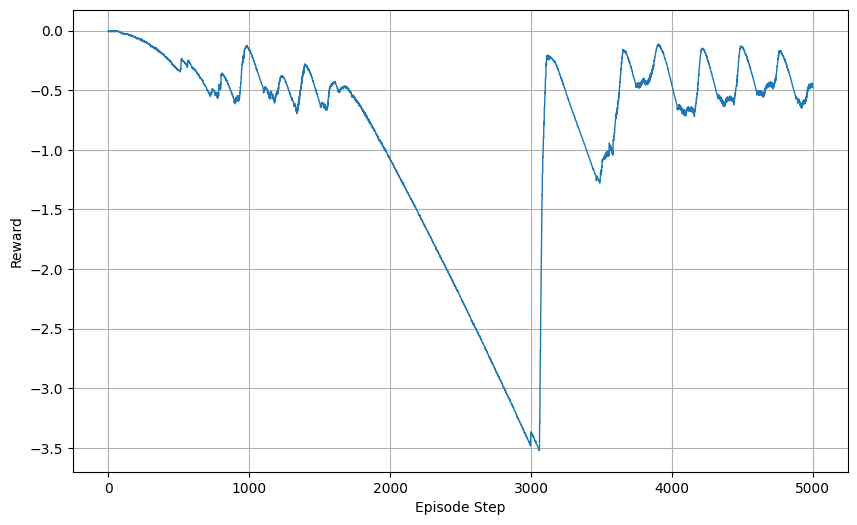

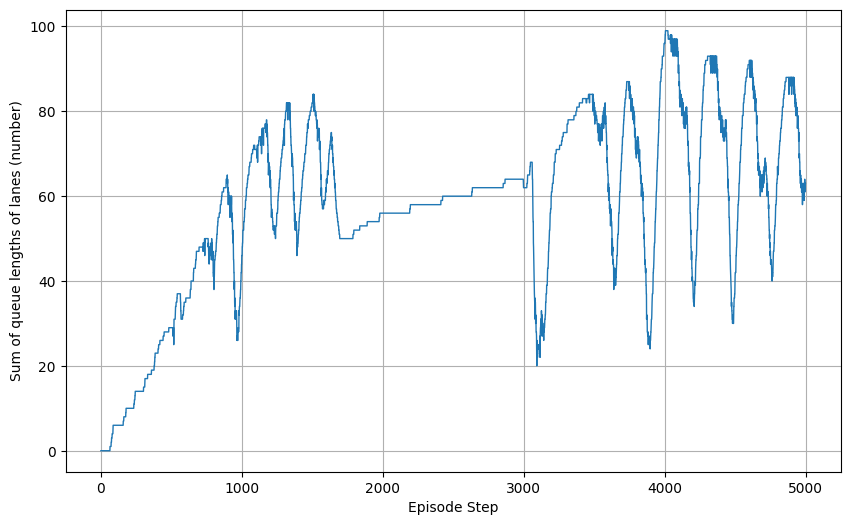

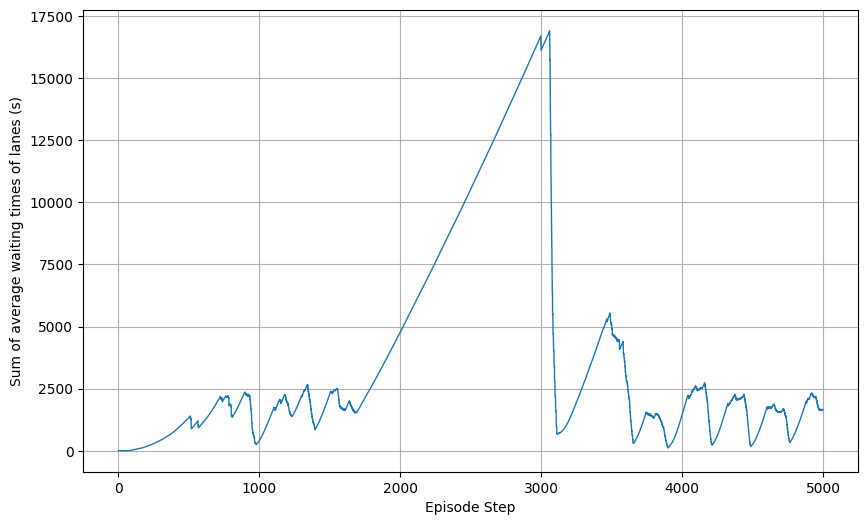

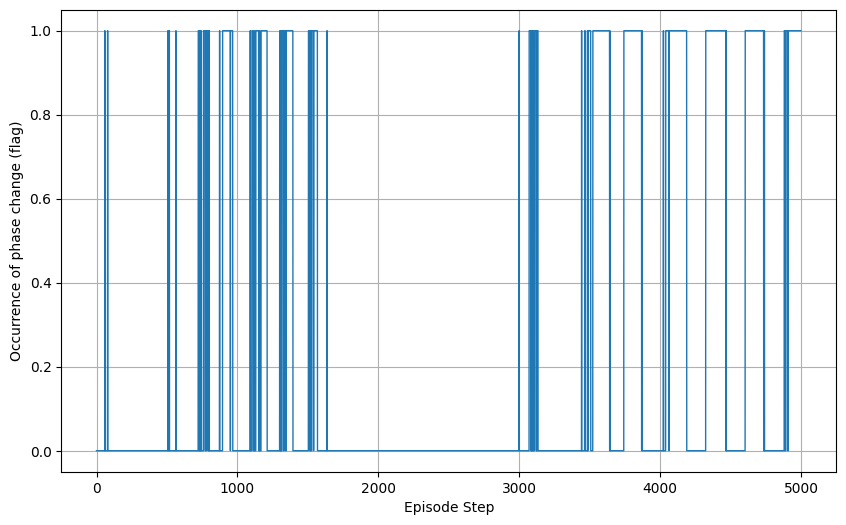

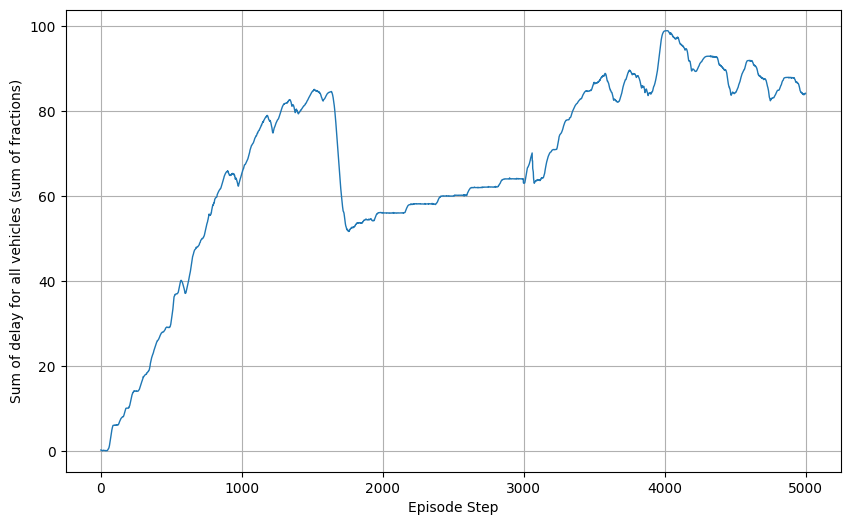

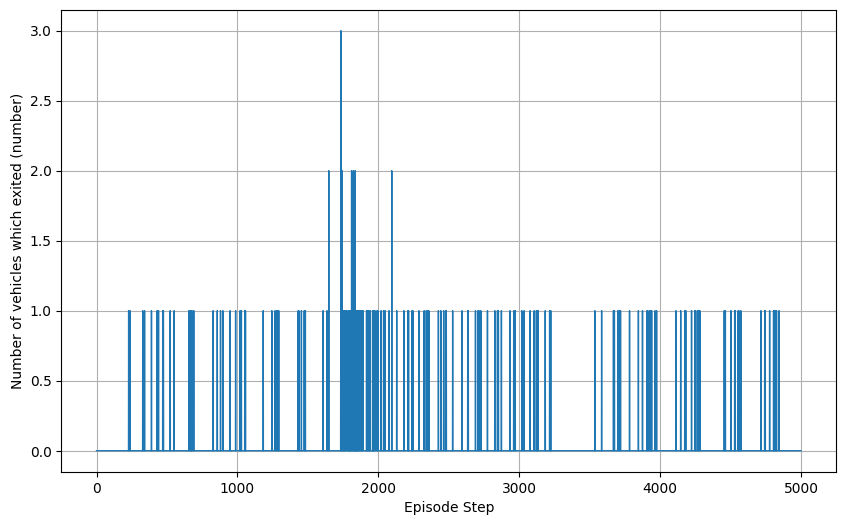

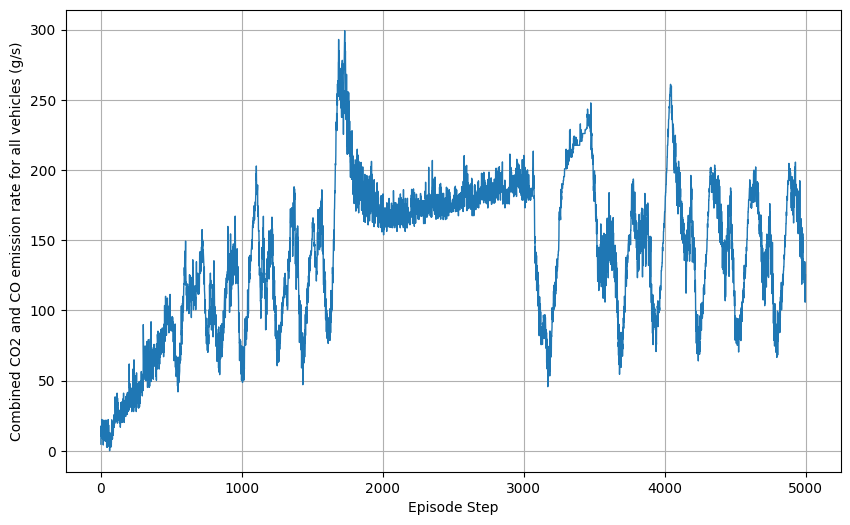

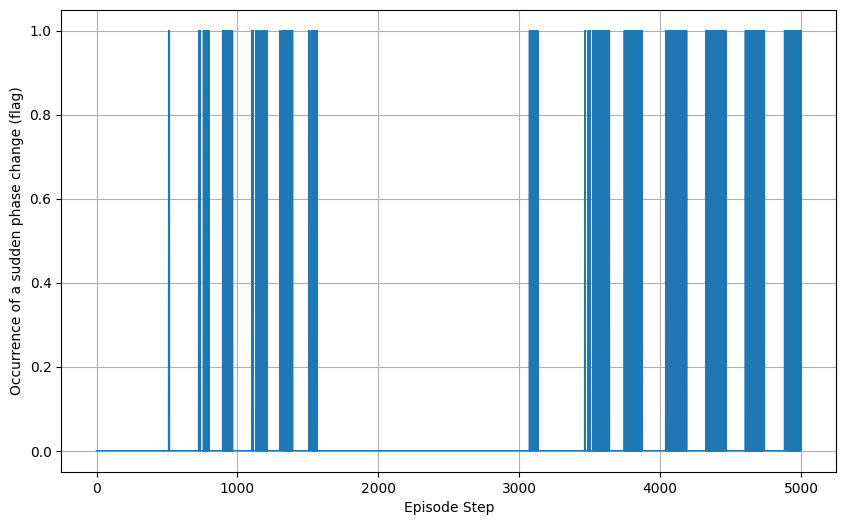

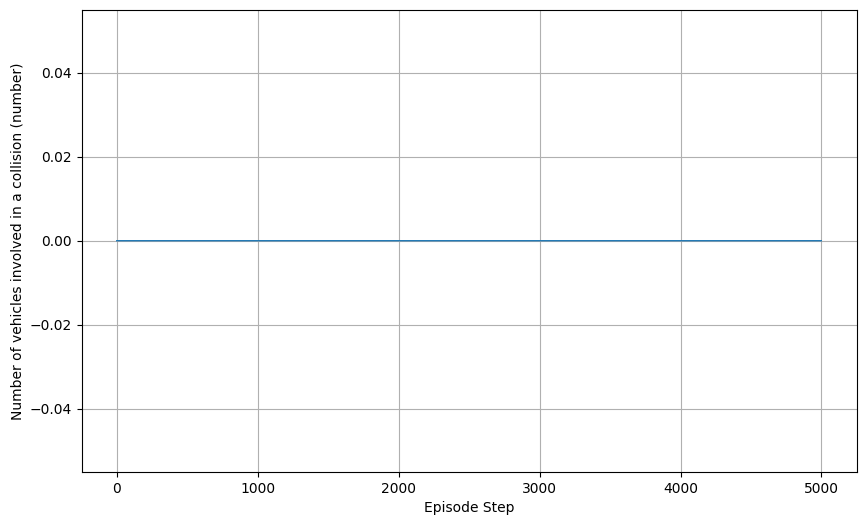

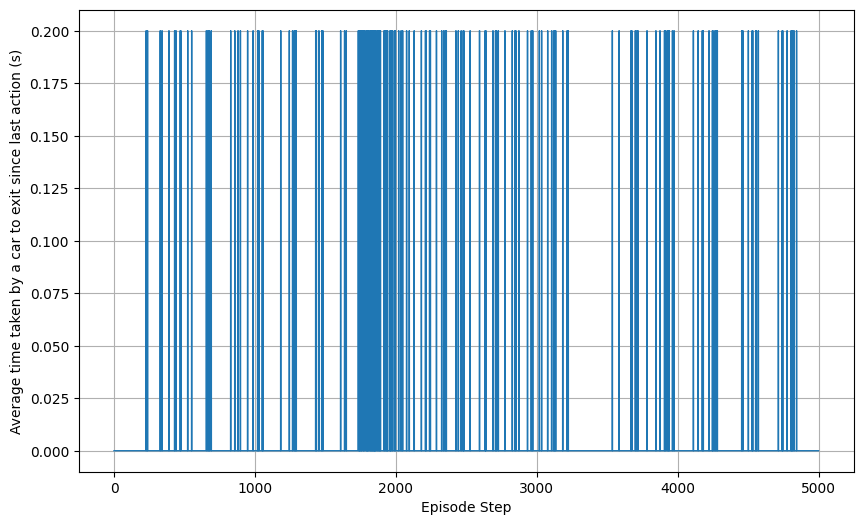

In [10]:
# Reward factor naming dictionary
naming_dict = {
    "queue_length": "Sum of queue lengths of lanes (number)",
    "avg_waiting_time": "Sum of average waiting times of lanes (s)",
    "phase_change": "Occurrence of phase change (flag)",
    "total_delay": "Sum of delay for all vehicles (sum of fractions)",
    "vehicles_passed": "Number of vehicles which exited (number)",
    "total_emissions": "Combined CO2 and CO emission rate for all vehicles (g/s)",
    "sudden_phase_change": "Occurrence of a sudden phase change (flag)",
    "num_collided_vehicles": "Number of vehicles involved in a collision (number)",
    "average_travel_time": "Average time taken by a car to exit since last action (s)"
}

# Number of steps for each episode
num_steps = len(eval_data[0])

# Initialize lists to store summed values for each step
reward_sums = []
reward_factor_sums = {
    "queue_length": [],
    "avg_waiting_time": [],
    "phase_change": [],
    "total_delay": [],
    "vehicles_passed": [],
    "total_emissions": [],
    "sudden_phase_change": [],
    "num_collided_vehicles": [],
    "average_travel_time": []
}
for i in range(num_steps):
    reward_sums.append(0)
    for key in reward_factor_sums:
        reward_factor_sums[key].append(0)

# Accumulate rewards and reward factors for each step across all episodes
for episode in eval_data:
    for step_index, (reward, reward_factors) in enumerate(episode):
        reward_sums[step_index] += reward
        
        for key in reward_factor_sums:
            reward_factor_sums[key][step_index] += reward_factors[key]

# Number of episodes
num_episodes = len(eval_data)

# Calculate the average for each step
average_rewards = [reward_sums[i] / num_episodes for i in range(num_steps)]

average_reward_factors = {
    key: [reward_factor_sums[key][i] / num_episodes for i in range(num_steps)]
    for key in reward_factor_sums
}

# Plotting
steps = np.arange(num_steps)  # X-axis for plotting

line_thickness = 1

# Plot average reward
plt.figure(figsize=(10, 6))
plt.plot(steps, average_rewards, linestyle='-', linewidth=line_thickness)
plt.xlabel("Episode Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Plot reward factors
for key, values in average_reward_factors.items():
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, linestyle='-', linewidth=line_thickness)
    plt.xlabel("Episode Step")
    plt.ylabel(naming_dict[key])
    plt.grid(True)
    plt.show()

In [11]:
# Function to compute min, max, mean and sum
def compute_stats(values):
    min_value = min(values)
    max_value = max(values)
    mean_value = np.mean(values)
    cumulative_value = sum(values)
    return min_value, max_value, mean_value, cumulative_value

# Compute and print the stats for average rewards
reward_min, reward_max, reward_mean, reward_cumulative = compute_stats(average_rewards)
print("Reward - Min:", reward_min)
print("Reward - Max:", reward_max)
print("Reward - Mean:", reward_mean)
print("Reward - Cumulative:", reward_cumulative)
print("")

# Compute and print the stats for each reward factor
for key, values in average_reward_factors.items():
    factor_min, factor_max, factor_mean, factor_cumulative = compute_stats(values)
    print(f"{naming_dict[key]} - Min:", factor_min)
    print(f"{naming_dict[key]} - Max:", factor_max)
    print(f"{naming_dict[key]} - Mean:", factor_mean)
    print(f"{naming_dict[key]} - Cumulative:", factor_cumulative)
    print("")

Reward - Min: -3.52430603345869
Reward - Max: -0.00044411250704520604
Reward - Mean: -0.8611931766160665
Reward - Cumulative: -4305.965883080316

Sum of queue lengths of lanes (number) - Min: 0.0
Sum of queue lengths of lanes (number) - Max: 99.0
Sum of queue lengths of lanes (number) - Mean: 58.0814
Sum of queue lengths of lanes (number) - Cumulative: 290407.0

Sum of average waiting times of lanes (s) - Min: 0.0
Sum of average waiting times of lanes (s) - Max: 16905.999999999996
Sum of average waiting times of lanes (s) - Mean: 3709.4460400000007
Sum of average waiting times of lanes (s) - Cumulative: 18547230.19999999

Occurrence of phase change (flag) - Min: 0.0
Occurrence of phase change (flag) - Max: 1.0
Occurrence of phase change (flag) - Mean: 0.2388
Occurrence of phase change (flag) - Cumulative: 1194.0

Sum of delay for all vehicles (sum of fractions) - Min: 0.030940502448194684
Sum of delay for all vehicles (sum of fractions) - Max: 98.9987866759157
Sum of delay for all vehi